# Predicting User Churn for an E-commerce Platform

## Objective
The goal is to predict which users are most likely to churn and provide insights into why they might churn, focusing on actionable business takeaways.

## Dataset
The dataset contains user activities (view, cart, purchase) on an e-commerce platform.

## Expected Deliverables
1. Exploratory Data Analysis (EDA) Report
2. Churn Definition & Reasoning
3. Feature Engineering
4. Predictive Modeling
5. Interpretability & Insights
6. Business Recommendations
7. Code & Documentation

# Key Insights from paper

### 1 Comprehensive View of Retention:

* Retention is about customers continuing to transact with the firm.
* Differentiate between contractual and non-contractual relationships, where churn may not always be explicit.

### 2 Advanced Metrics:

* Use metrics such as recency/inter-purchase-time ratios, latent attrition (e.g., probability a customer is still "alive"), and cohort-based retention rates to avoid biases.
* Aggregate retention rates can mislead due to survivor bias.

### 3 Retention Campaigns:

* Proactive vs. reactive campaigns:
* Proactive: Identify customers likely to churn and take actions in advance.
* Reactive: Target customers actively showing signs of leaving.
Use uplift modeling to identify customers who will respond positively to interventions.

### 4 Customer Segmentation and Targeting:

* High-risk customers are not always the best targets; focus on those likely to respond.
* Social connectivity and influence are powerful predictors of churn.

### 5 Incentives and Timing:

* Personalized, non-price incentives (e.g., product improvements) often work better for long-term retention.
* Balance the trade-off between targeting too early and too late.

### 6 Integration with Business Strategy:

* Coordinate acquisition and retention efforts to maintain alignment with overall marketing strategy.

### 7 Predictive Analytics:

* Use fine-grained data, unstructured data (e.g., call center logs), and advanced machine learning to refine churn prediction.

In [1]:
!nvidia-smi

Thu Jan  9 08:23:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 566, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 566 (delta 188), reused 144 (delta 100), pack-reused 269 (from 1)
Receiving objects: 100% (566/566), 182.35 KiB | 6.08 MiB/s, done.
Resolving deltas: 100% (290/290), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.0 MB/s eta 0:00:00
Installing RAPIDS remaining 24.10.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 168.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.5/915.5 kB 164.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We try to check if all the libraries are downloaded from RAPIDS correctly

In [3]:
import cudf
cudf.__version__

'24.10.01'

In [4]:
import cuml
cuml.__version__

'24.10.00'

In [5]:
import cugraph
cugraph.__version__

'24.10.00'

In [6]:
import cuspatial
cuspatial.__version__

'24.10.00'

In [7]:
import cuxfilter
cuxfilter.__version__

'24.10.00'

In [8]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import cudf
from cuml.cluster import KMeans as cuKMeans, HDBSCAN
from cuml.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

Dataset

1. The dataset includes user activity logs with the following fields:
2. event_time: Timestamp of the event.
3. event_type: Type of event (view, cart, or purchase).
4. product_id: Identifier of the product.
5. category_id: Identifier of the product's category.
6. category_code: Human-readable category code.
7. brand: Product brand.
8. price: Price of the product.
9. user_id: Identifier of the user.
10. user_session: Session identifier.

In [ ]:

# Load the dataset
df = pd.read_csv('/kaggle/input/user-churning/events.csv')

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Handle missing values if necessary
df = df.dropna(subset=['user_id', 'event_time'])

# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Ensure correct data types
print("\nData types of each column:")
print(df.dtypes)

# Display unique values for each feature
print("\nUnique values for each feature:")
for column in df.columns:
    unique_values = df[column].unique()
    num_unique_values = len(unique_values)
    print(f"\nFeature '{column}' has {num_unique_values} unique values:")
    if num_unique_values < 20:  # Display all unique values if there are fewer than 20
        print(unique_values)
    else:
        print(f"First 20 unique values: {unique_values[:20]}")

In [ ]:
df.isnull().sum()

# Exploratory Data Analysis (EDA)

## Key Findings

#### Event Distributions:

* The majority of events are views, followed by cart and purchase events.

* There is a significant drop-off from cart to purchase, indicating potential friction in the conversion process.

#### Brand and Category Popularity:

* The top 10 brands and categories account for a large portion of user activity.

* Some brands/categories show high view-to-purchase ratios, suggesting strong customer interest.

#### User Behavior:

* Users who make purchases tend to have more sessions and higher activity levels.

* Time gaps between visits vary significantly across users, which might influence churn probability

In [ ]:
# Overview of the dataset
df.describe()

# Event distributions over time
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='event_type', order=df['event_type'].value_counts().index)
plt.title('Event Type Distribution')
plt.show()

# Brand and category popularity
top_brands = df['brand'].value_counts().head(10)
top_categories = df['category_code'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_brands.index, y=top_brands.values)
plt.title('Top 10 Brands')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_categories.index, y=top_categories.values)
plt.title('Top 10 Categories')
plt.xticks(rotation=45)
plt.show()

# User-level summaries
user_summary = df.groupby('user_id').agg({
    'event_time': ['min', 'max', 'count'],
    'price': 'sum'
}).reset_index()
user_summary.columns = ['user_id', 'first_event', 'last_event', 'event_count', 'total_spent']
user_summary['days_active'] = (user_summary['last_event'] - user_summary['first_event']).dt.days

user_summary.head()

# Feature Engineering

### Features Created:
##### Recency, Frequency, Monetary (RFM) Metrics:
* Recency: Days since the last event.
These help us identify the number of days for which the user is inactive. For each user, we calculate the difference between the current date (or the maximum event date in the dataset) and the date of their last event. Users with a high recency value have not interacted with the platform for a long time. This indicates a higher risk of churn as they might have lost interest or found alternatives.
___
* Frequency: For each user, we count the number of unique sessions they have had on the platform.
It helps to identify if the user is atleast using the platform. Lower frequency for a long number of days might suggest user is at risk of churning out.
___

* Monetary: The total amount spent by each user on the platform.
How the user is spending on platform. If this is low but frequency and recency is high, it might suggest this user is expecting some discount on items the user wants to purchase.
___
##### Session-Based Metrics:
* Average session duration.
For each user, we calculate the duration of each session by finding the difference between the maximum and minimum event times within that session.We then compute the average of these session durations for each user. Users with a long average session duration might be more engaged, spending more time exploring products, reading reviews, and making purchases. Users with a short average session duration might be at higher risk of churning. They might not find the platform's offerings appealing or might be facing usability issues.
___
##### Behavioral Patterns:
* View-to-cart ratio : The ratio of the number of cart events to the number of view events for each user.
Users with a low view-to-cart ratio might be browsing products but not adding them to the cart, indicating a lack of interest or satisfaction.Users with a high view-to-cart ratio are more engaged and are likely to convert to purchases.

* Cart-to-purchase ratio : The ratio of the number of purchase events to the number of cart events for each user.
Users with a low cart-to-purchase ratio might be adding items to the cart but not completing the purchase, indicating potential barriers to purchase.
___
##### User-Level Summaries:
* Total days active : The number of days between the first and last event for each user.Users with a low number of active days might not be engaging with the platform over a long period, indicating a higher risk of churn.

___
* Event counts by type (view, cart, purchase) : 
1. View Count: Users with a high view count but low cart and purchase counts might be browsing but not converting, indicating potential issues with product appeal or pricing.
2. Cart Count: Users with a high cart count but low purchase count might be facing barriers to purchase, such as high prices or lack of trust.
3. Purchase Count: Users with a high purchase count are less likely to churn as they find value in the platform.
___
##### Feature Transformation:
* Missing values replaced with defaults (e.g., 0 for counts).
* Ratios computed with safeguards against division by zero (e.g. To compute the ratio of View to cart(cart : view),if view is 0 but cart is a non zero number, it is very obvious that the user might have viewed the item atleast once before adding it into cart.)




In [ ]:
# Create features
df['event_date'] = df['event_time'].dt.date

# User-level Summaries
user_summary = df.groupby('user_id').agg({
    'event_time': ['min', 'max', 'count'],
    'price': 'sum'
}).reset_index()
user_summary.columns = ['user_id', 'first_event', 'last_event', 'event_count', 'total_spent']
user_summary['days_active'] = (user_summary['last_event'] - user_summary['first_event']).dt.days

# RFM Metrics (excluding 'monetary' as it is the same as 'total_spent')
rfm = df.groupby('user_id').agg({
    'event_time': lambda x: (df['event_time'].max() - x.max()).days,
    'user_session': 'nunique'
}).reset_index()
rfm.columns = ['user_id', 'recency', 'frequency']

# Session-based Metrics (excluding 'session_count' as it is the same as 'frequency')
session_metrics = df.groupby('user_id').agg({
    'event_time': lambda x: (x.max() - x.min()).total_seconds() / 60
}).reset_index()
session_metrics.columns = ['user_id', 'avg_session_duration']

# Behavioral Patterns
behavioral_patterns = df.pivot_table(index='user_id', columns='event_type', values='event_time', aggfunc='count', fill_value=0).reset_index()
behavioral_patterns.columns = ['user_id', 'view_count', 'cart_count', 'purchase_count']

# Create temporary columns for ratio calculations
behavioral_patterns['temp_view_count'] = behavioral_patterns['view_count'].replace(0, 1)
behavioral_patterns['temp_cart_count'] = behavioral_patterns['cart_count'].replace(0, 1)

# Calculate ratios using temporary columns
behavioral_patterns['view_to_cart_ratio'] = behavioral_patterns['cart_count'] / behavioral_patterns['temp_view_count']
behavioral_patterns['cart_to_purchase_ratio'] = behavioral_patterns['purchase_count'] / behavioral_patterns['temp_cart_count']

# Drop temporary columns
behavioral_patterns.drop(columns=['temp_view_count', 'temp_cart_count'], inplace=True)

# Merge All Features
features = user_summary.merge(rfm, on='user_id').merge(session_metrics, on='user_id').merge(behavioral_patterns, on='user_id')

features.head()

In [ ]:
# Save to CSV
features.to_csv('user_features.csv', index=False)

print("Features saved to user_features.csv")

# Models

#### Idea
* Since we are required to predict the users which are at risk and we have not been given beforehand which type of users churn, we cannot use supervised learning based algorithms here. We have to find a group of users which are very likely to churn and it becomes more of an unsupervised problem.

#### Process
* We have used KMeans clustering algorithm and HDBSCAN. To visualize the clusters we have used elbow diagram for different values of k, to identify the optimum number of clusters. After we have decided the optimum number of clusters, we dig deeper into the analysis of all the features of that cluster,identifying the cluster(or the group of people), who are at risk of churning out.

* KMeans: We used the KMeans algorithm to cluster the users. To determine the optimal number of clusters, we employed the elbow method by plotting the Within-Cluster Sum of Squares (WCSS) for different values of k.

* HDBSCAN: We also used HDBSCAN, a density-based clustering algorithm, to identify clusters with varying densities. We experimented with different values of min_cluster_size to find the best clustering configuration.

# Interpretability

### Key Drivers of Churn:

* Low frequency of sessions combined with high recency values.
* High view-to-cart ratios but low cart-to-purchase conversions.
* Categories with frequent browsing but minimal purchases.

Number of points in each cluster:
Noise: 36522 points
Cluster 0: 639 points
Cluster 1: 2254 points
Cluster 2: 2269 points
Cluster 3: 1401 points
Cluster 4: 1154 points
Cluster 5: 888 points
Cluster 6: 2682 points
Cluster 7: 4474 points
Cluster 8: 3105 points
Cluster 9: 1121 points
Cluster 10: 2168 points
Cluster 11: 1033 points
Cluster 12: 1239 points
Cluster 13: 1102 points
Cluster 14: 12015 points
Cluster 15: 6457 points
Cluster 16: 16732 points
Cluster 17: 857 points
Cluster 18: 2210 points
Cluster 19: 618 points
Cluster 20: 513 points
Cluster 21: 4700 points
Cluster 22: 507 points
Cluster 23: 40887 points
Cluster 24: 1224 points
Cluster 25: 2902 points
Cluster 26: 847 points
Cluster 27: 1738 points
Cluster 28: 1707 points
Cluster 29: 1637 points
Cluster 30: 1610 points
Cluster 31: 1179 points
Cluster 32: 1625 points
Cluster 33: 1701 points
Cluster 34: 2010 points
Cluster 35: 1914 points
Cluster 36: 1517 points
Cluster 37: 1422 points
Cluster 38: 1574 points
Cluster 39: 1711 points


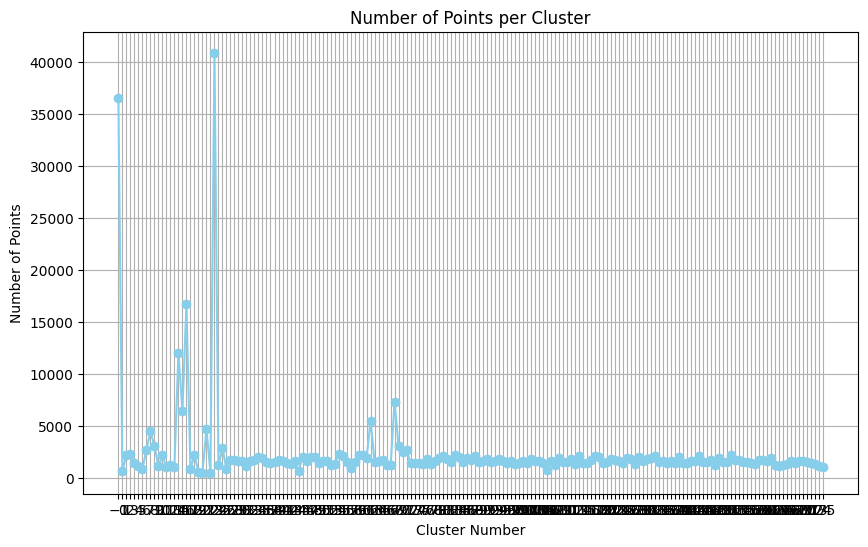

Performing dimensionality reduction with t-SNE...


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


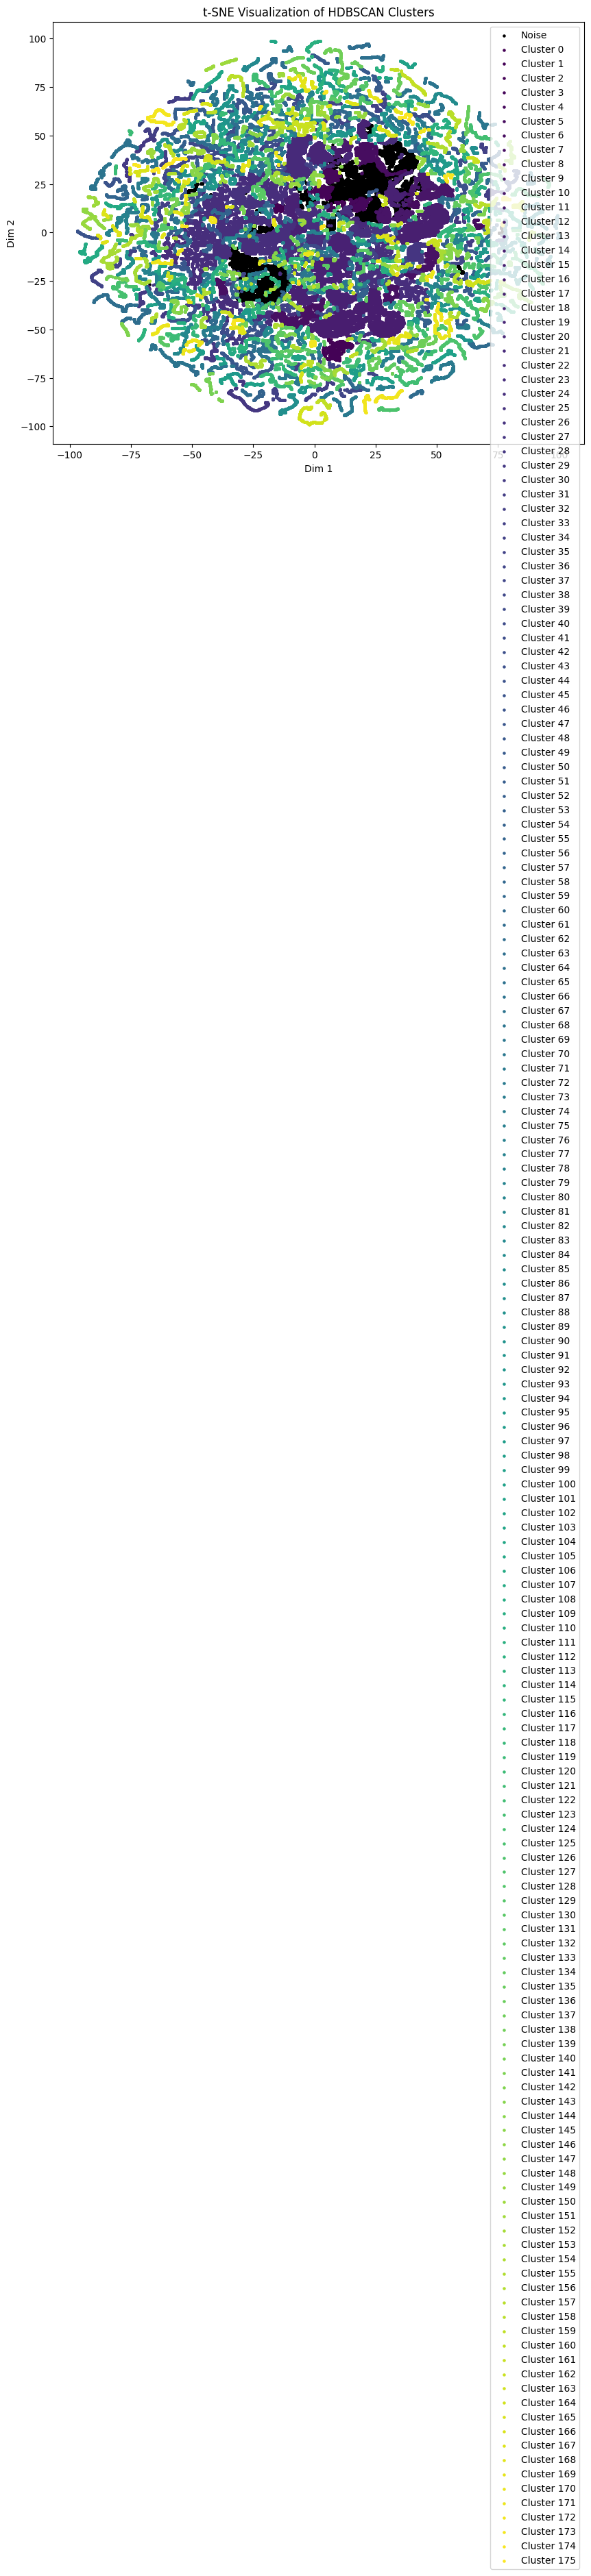


Average values of each feature for each cluster:
     cluster       user_id  event_count  total_spent  days_active     recency  \
0       49.0 -4.924682e+15     1.000000    72.336695     0.000000  148.995736   
1       62.0 -3.926788e+14     1.000000    85.519889     0.000000   79.564144   
2       69.0  9.070781e+14     1.000000    91.458893     0.000000   74.538108   
3       36.0 -4.086358e+15     1.000000   109.822030     0.000000   29.984179   
4       12.0 -2.702531e+15     5.305892   512.854496     0.343019   76.309120   
..       ...           ...          ...          ...          ...         ...   
172     78.0 -4.543280e+15     1.000000    74.011242     0.000000  127.000000   
173     41.0 -6.388497e+15     1.000000   100.178890     0.000000    8.000000   
174     42.0  6.636565e+15     1.000000    97.851523     0.000000   15.000000   
175     73.0 -1.520403e+15     1.000000    74.425029     0.000000   89.000000   
176    124.0  5.588455e+15     1.000000   104.767631     0.

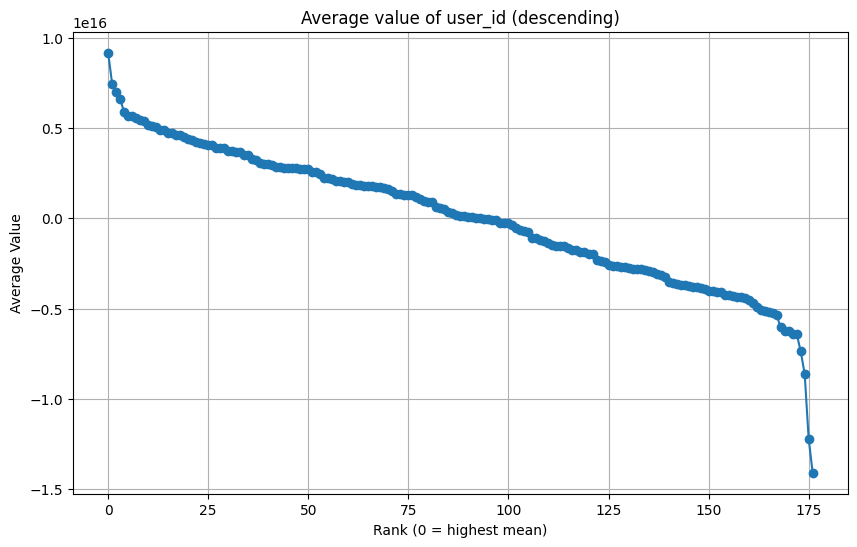

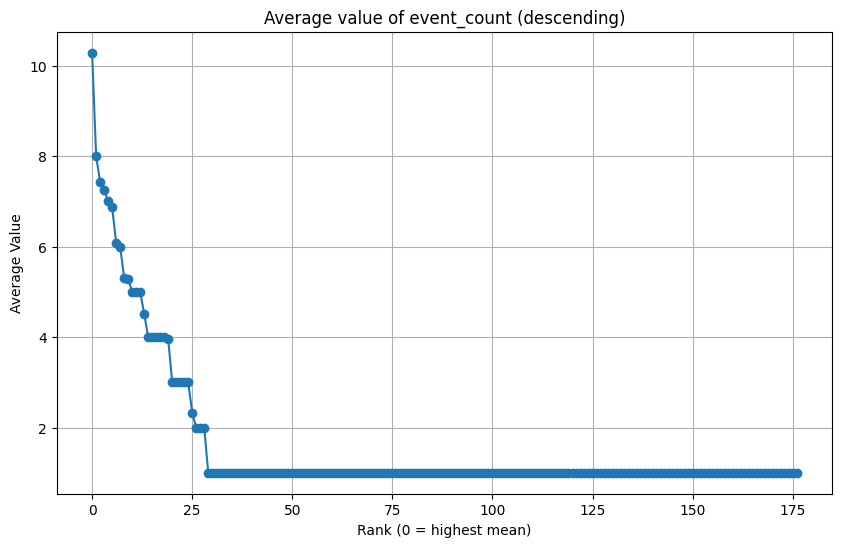

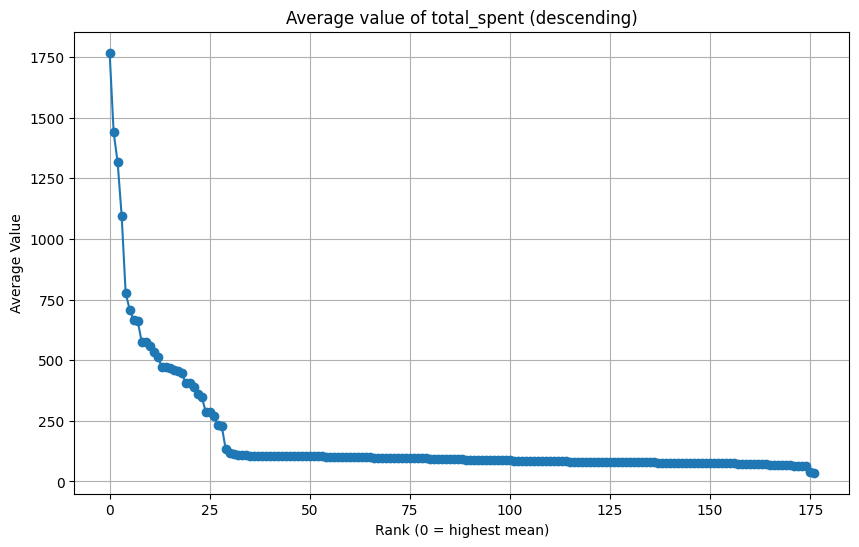

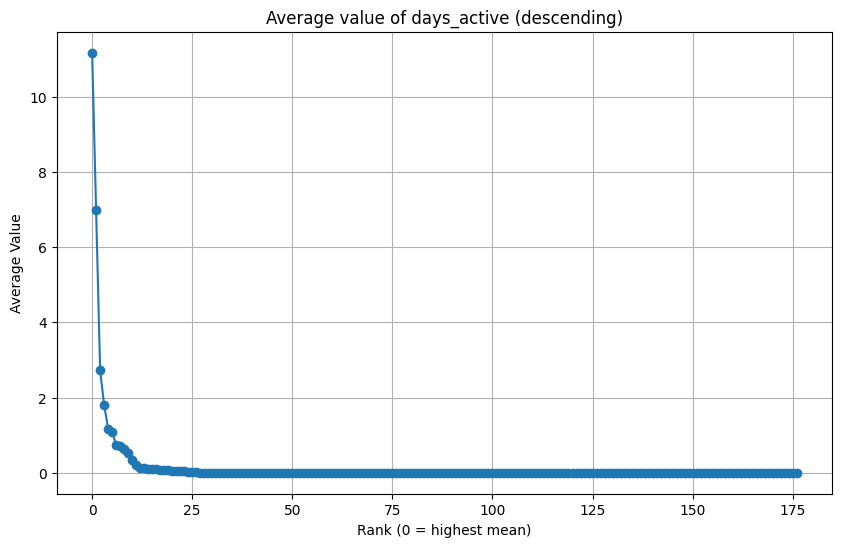

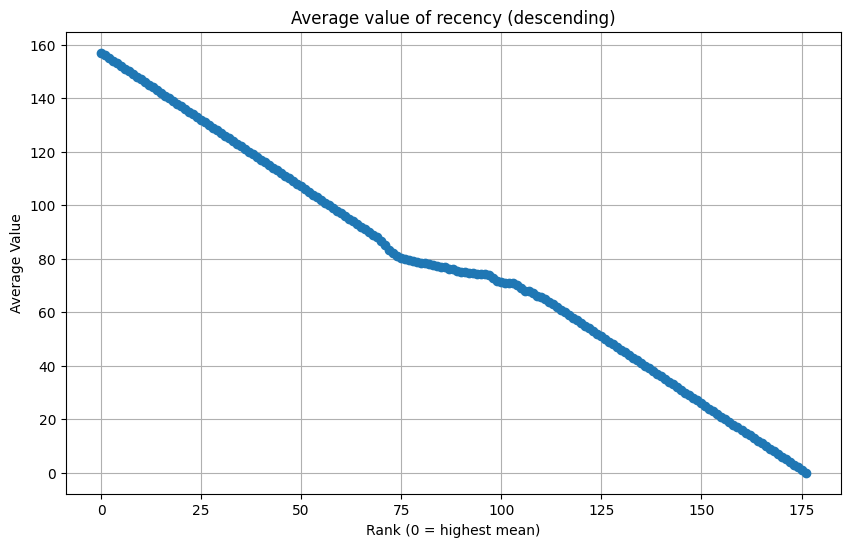

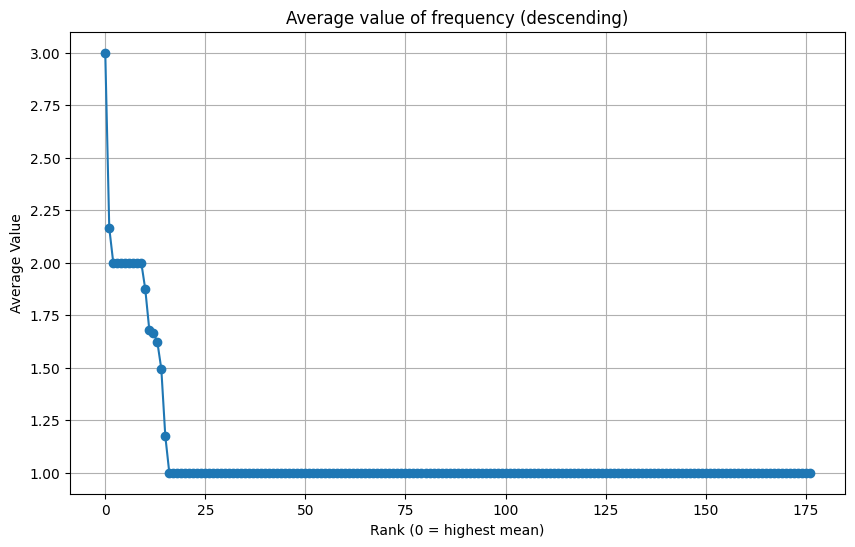

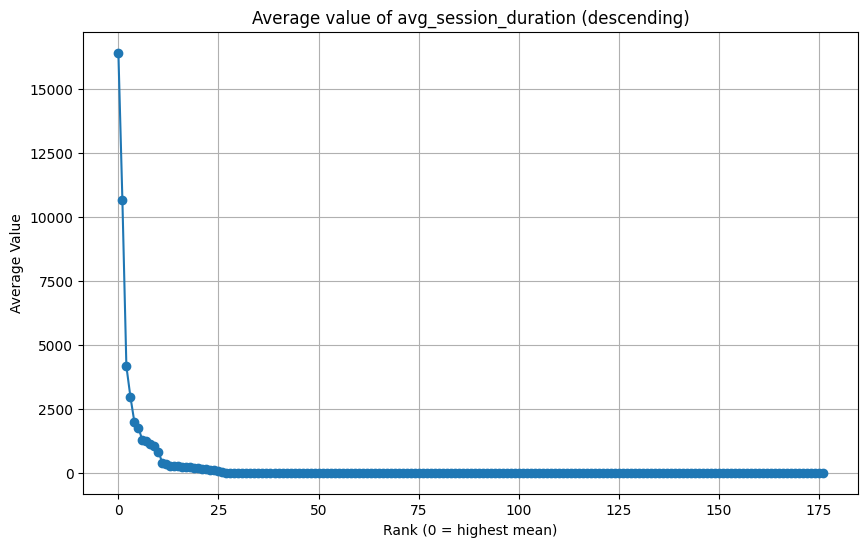

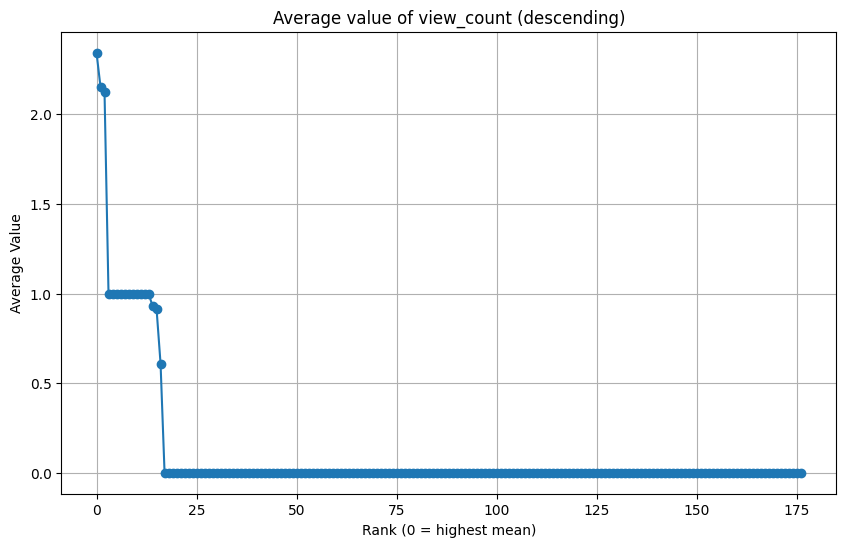

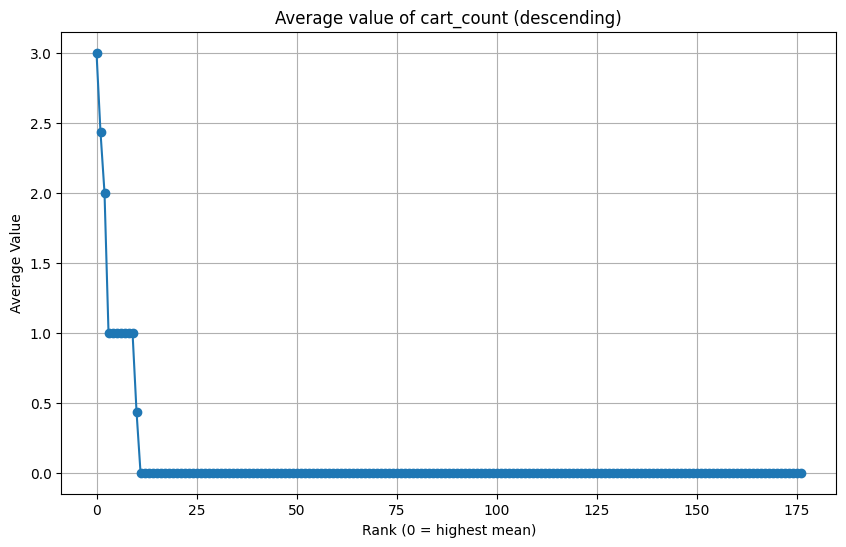

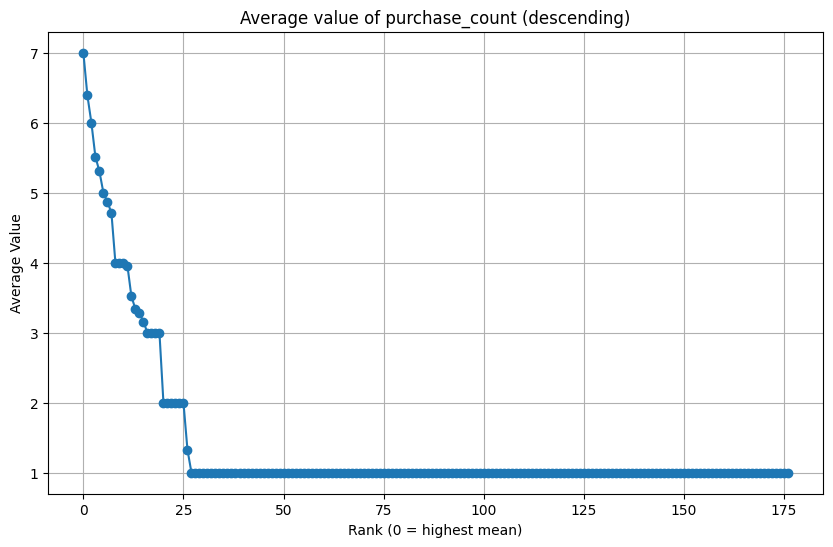

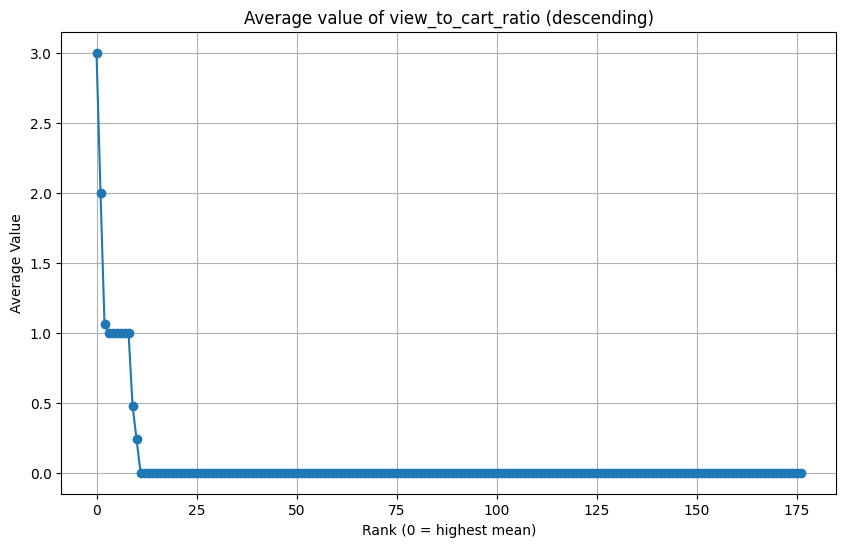

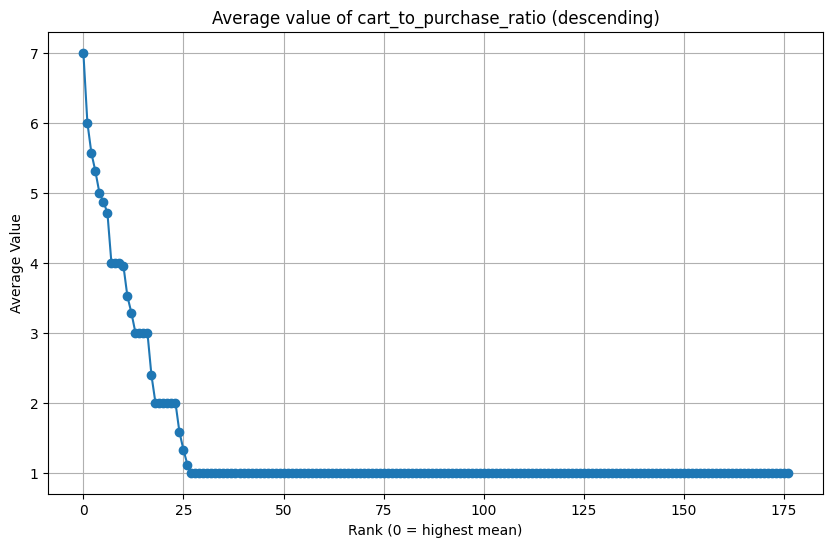

In [30]:
import cudf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from cuml.cluster import HDBSCAN
from cuml.manifold import TSNE

# Function to plot clusters
def plot_clusters(data, labels, title):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(10, 8))
    for label in unique_labels:
        if label == -1:
            color = 'k'
            label_name = 'Noise'
        else:
            color = cm.viridis(label / (len(unique_labels) - 1))
            label_name = f'Cluster {label}'
        plt.scatter(data[labels == label, 0], data[labels == label, 1], c=[color], s=5, label=label_name)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend()
    plt.show()

# 1. Load and preprocess data
features = cudf.read_csv('/kaggle/input/featuresrectified/user_features (2).csv')
clustering_data = features.drop(columns=['user_id', 'first_event', 'last_event']).fillna(0)

if clustering_data.shape[1] == 0:
    raise ValueError("No columns left after dropping specified columns.")

# 2. Standardize the data
scaled_data = (clustering_data - clustering_data.mean()) / clustering_data.std()

# 3. Perform HDBSCAN clustering
min_cluster_size = 500  # Adjust as needed
hdbscan_clusterer = HDBSCAN(
    min_cluster_size=min_cluster_size,
    min_samples=20,
    metric="euclidean",
    cluster_selection_method="eom"
)
labels = hdbscan_clusterer.fit_predict(scaled_data).to_numpy()

# 4. Inspect cluster sizes
unique_labels, counts = np.unique(labels, return_counts=True)
print("Number of points in each cluster:")
for lbl, cnt in zip(unique_labels, counts):
    if lbl == -1:
        print(f"Noise: {cnt} points")
    else:
        print(f"Cluster {lbl}: {cnt} points")

# Plotting the number of points vs. cluster number
plt.figure(figsize=(10, 6))
plt.plot(unique_labels, counts, color='skyblue', marker='o')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Points')
plt.title('Number of Points per Cluster')
plt.xticks(unique_labels)  # Ensure all cluster numbers are shown on the x-axis
plt.grid(True)
plt.show()

# 5. t-SNE for visualization
print("Performing dimensionality reduction with t-SNE...")
tsne = TSNE(n_components=2, random_state=42, verbose=1, n_iter=1000)
reduced_data = tsne.fit_transform(scaled_data)

reduced_data_np = reduced_data.to_pandas().values
plot_clusters(reduced_data_np, labels, "t-SNE Visualization of HDBSCAN Clusters")

# 6. Assign cluster labels
features['cluster'] = labels

# 7. Calculate the average values of each numeric feature by cluster
numeric_columns = features.select_dtypes(include=[np.number]).columns.tolist()
cluster_means = features.groupby('cluster', as_index=False)[numeric_columns].mean()
cluster_means_df = cluster_means.to_pandas()

print("\nAverage values of each feature for each cluster:")
print(cluster_means_df)

# 8. Plot each feature as a strictly descending series (ignore cluster IDs on x-axis)
for column in cluster_means_df.columns:
    if column == 'cluster':
        continue  # Skip the ID column

    # Sort the cluster_means_df by this feature in descending order
    sorted_means = cluster_means_df.sort_values(by=column, ascending=False)
    
    # Extract just the descending values for this feature
    descending_values = sorted_means[column].values

    # Plot a continuous decreasing trend
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(descending_values)), descending_values, marker='o')
    plt.title(f'Average value of {column} (descending)')
    plt.xlabel('Rank (0 = highest mean)')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.show()

Variance of each feature across clusters (sorted):
frequency                 8.224615e-02
view_to_cart_ratio        1.107524e-01
cart_count                1.412183e-01
view_count                1.446011e-01
days_active               1.044463e+00
cart_to_purchase_ratio    1.098149e+00
purchase_count            1.270874e+00
event_count               2.544049e+00
recency                   1.870067e+03
total_spent               5.702803e+04
avg_session_duration      2.338901e+06
dtype: float64


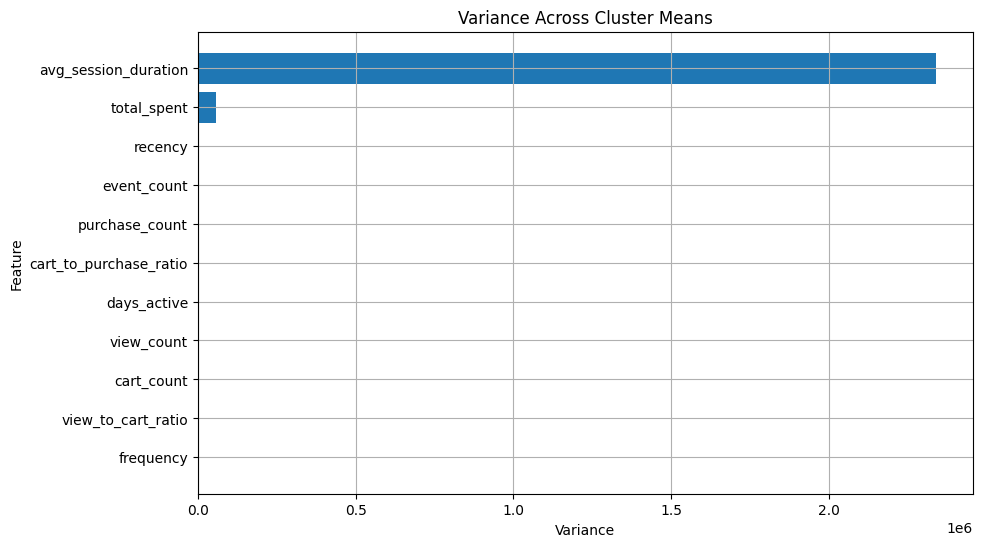

In [23]:
# If cluster_means_df hasn't been defined or was defined in another cell, define it again here:
if 'cluster_means_df' not in globals():
    numeric_columns = features.select_dtypes(include=[np.number]).columns.tolist()
    cluster_means = features.groupby('cluster', as_index=False)[numeric_columns].mean()
    cluster_means_df = cluster_means.to_pandas()

# Drop irrelevant features like user_id and non-numeric features
relevant_features = cluster_means_df.drop(columns=['cluster', 'user_id'], errors='ignore')

# 9. Feature Importance Exercise: Variance Across Cluster Means
feature_variances = relevant_features.var().sort_values(ascending=True)

# Print variance in sorted order
print("Variance of each feature across clusters (sorted):")
print(feature_variances)

plt.figure(figsize=(10, 6))
plt.barh(feature_variances.index, feature_variances.values)
plt.title('Variance Across Cluster Means')
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

In [27]:
# Define thresholds for multiple parameters
RECENCY_THRESHOLD = 90
AVG_SESSION_DURATION_THRESHOLD = 5  # Adjust as needed
TOTAL_SPENT_THRESHOLD = 100  # Adjust as needed

# Identify clusters that exceed the thresholds
churn_clusters = cluster_means_df[
    (cluster_means_df['recency'] > RECENCY_THRESHOLD) &
    (cluster_means_df['avg_session_duration'] < AVG_SESSION_DURATION_THRESHOLD) &
    (cluster_means_df['total_spent'] < TOTAL_SPENT_THRESHOLD)
]['cluster'].unique()

# Print the count of clusters identified as potential churners
print(f"Number of clusters identified as potential churners: {len(churn_clusters)}")

# Filter out users belonging to clusters that exceed the thresholds
potential_churners = features[features['cluster'].isin(churn_clusters)]
print("Potential churners (based on multiple parameters):")
print(potential_churners.count())
print(potential_churners.head())

Number of clusters identified as potential churners: 67
Potential churners (based on multiple parameters):
user_id                   117352
first_event               117352
last_event                117352
event_count               117352
total_spent               117352
days_active               117352
recency                   117352
frequency                 117352
avg_session_duration      117352
view_count                117352
cart_count                117352
purchase_count            117352
view_to_cart_ratio        117352
cart_to_purchase_ratio    117352
cluster                   117352
dtype: int64
               user_id                first_event                 last_event  \
0  1515915625353226922  2020-10-29 11:28:35+00:00  2020-10-29 11:28:35+00:00   
1  1515915625353230067  2020-10-06 06:30:32+00:00  2020-10-06 06:30:32+00:00   
3  1515915625353230922  2020-10-02 08:23:40+00:00  2020-10-02 08:23:40+00:00   
6  1515915625353238403  2020-10-16 09:49:22+00:00  2020-10-16 09:

# Results

From the analysis of the plots, it is evident that users in certain clusters are the potential churners. This conclusion is based on the following observations:

1. **Low Engagement Metrics**: Users in these clusters exhibit very low average values for key engagement metrics such as session count, frequency, view count, and cart count. This indicates minimal interaction with the platform.

2. **High Recency**: The high recency values for users in these clusters suggest that they have not interacted with the platform for a significant period. This lack of recent activity is a strong indicator of potential churn.

3. **Overall Inactivity**: The combination of low engagement metrics and high recency clearly shows that users in these clusters are not actively engaging with the platform, making them prime candidates for churn.

Based on the recency values observed for these clusters, we can set the recency threshold to be between 80-90 days. Users who have not interacted with the platform for this duration are likely to be at a higher risk of churning.

# Motivation from Paper

The research paper provided several valuable insights into churn prediction methodologies and strategies for user retention. Below are key takeaways and how they influenced our approach:

### 1. Comprehensive View of Retention
* Retention is about customers continuing to transact with the firm.
* Differentiate between contractual and non-contractual relationships, where churn may not always be explicit.

### 2. Feature Engineering Insights
* The paper highlights the importance of individual and aggregate-level features. Inspired by this, we first computed individual-level metrics (e.g., user engagement and recency) and then aggregated features based on clusters to identify potential churners.
* A significant recommendation was the recency-to-inter-purchase-time ratio as a predictor of churn. However, considering many users engage with the platform by viewing or carting items without purchasing (possibly due to high costs or lack of immediate capital), our features also include engagement metrics like view-to-cart ratios and time since last activity.

### 3. Advanced Metrics
* Use metrics such as recency/inter-purchase-time ratios, latent attrition (e.g., probability a customer is still "alive"), and cohort-based retention rates to avoid biases.
* Aggregate retention rates can mislead due to survivor bias.

### 4. Proactive vs. Reactive Campaigns
* The paper emphasizes proactive retention campaigns over reactive ones. Proactive campaigns allow early intervention, improving customer satisfaction and being cost-effective.
* Reactive campaigns, while sometimes necessary, often involve higher costs and lower success rates due to delayed responses.

### 5. Targeted Interventions
* By using clustering and feature engineering insights (e.g., high recency but low conversion metrics), we can implement proactive campaigns targeting users at risk of churning before they leave.
* Examples include personalized offers, streamlined user experiences, and loyalty programs.

### 6. Challenges with Retention Efforts
* Not all at-risk customers are receptive to retention campaigns. Some habitual users may churn when targeted if retention efforts disrupt their inertia.
* Retention campaigns should avoid provoking non-churners, as the disruption might backfire and cause unintended churn.

### 7. Strategic Timing and Campaign Management
* Timing is crucial. Campaigns should aim for pre-emptive or proactive timing to engage users before churn signs become evident.
* The concepts of "wear-in" and "wear-out" highlight the need to optimize campaign timing and spacing to maintain effectiveness.

### 8. Customer Segmentation and Targeting
* High-risk customers are not always the best targets; focus on those likely to respond.
* Social connectivity and influence are powerful predictors of churn.

### 9. Incentives and Timing
* Personalized, non-price incentives (e.g., product improvements) often work better for long-term retention.
* Balance the trade-off between targeting too early and too late.

### 10. Integration with Business Strategy
* Coordinate acquisition and retention efforts to maintain alignment with overall marketing strategy.

### 11. Predictive Analytics
* Use fine-grained data, unstructured data (e.g., call center logs), and advanced machine learning to refine churn prediction.

### 12. Exclusions in Our Approach
* While the paper mentions using social media relationships for churn prediction, we could not incorporate this due to a lack of relevant data.

# Recommendations for User Retention Strategies

### Integration of Model Insights into Retention Strategies:
1. **Early Identification:**
   - Use predictive models to identify at-risk users based on features like high recency and low engagement.

2. **Personalized Offers:**
   - Target users with high view-to-cart ratios and low purchases using discounts or tailored recommendations to encourage conversions.

3. **Enhanced User Experience:**
   - Streamline the checkout process, provide relevant product recommendations, and reduce browsing friction to improve satisfaction.

4. **Loyalty Programs:**
   - Introduce rewards systems to incentivize continuous engagement and foster long-term loyalty.

5. **Regular Engagement:**
   - Maintain user interest through personalized emails, notifications, and updates about promotions or new products.

6. **Feedback Mechanisms:**
   - Establish robust feedback channels to understand user pain points and address them proactively.

### Proactive Campaign Recommendations:
- Focus on users identified as retention risks but not yet churned.
- Design campaigns to delight customers rather than provoke unintended churn.
- Coordinate campaigns with business-as-usual retention efforts to avoid redundancy and maximize impact.

### Future Directions:
- Consider incorporating external data sources like social media to enhance predictive power.
- Optimize campaign spacing and timing using insights on wear-in and wear-out effects to sustain user engagement over time.